# Two KDD comparison, 3D, using gamma analysis approach

In [2]:
import struct
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from npgamma import calc_gamma

In [3]:
kdd_reference  = "D:/XcDoseData/R5/PlanEngineResource/R5/Kdd/R5O3IL08_Y000Z000C025.d3d"
kdd_evaluation = "D:/XcDoseData/RX/PlanEngineResource/RX/Kdd/RXO3IL08_Y000Z000C025.d3d"

## Helper code to load KDDs (shared with Ottawa)

In [4]:
def remake_boundary(f, n: int, sym: bool):
    """
    Given filestream f and number of points n and symmetry flag sym,
    remake the boundary array
    """
    b = np.empty(n + 1, dtype = np.float32)

    for k in range(0, n + 1):
        b[k] = struct.unpack('f', f.read(4))[0]

    return b


def readKDD(fname: str):
    """
    Given the file name, read and return data from KDD file
    """
    with open(fname, mode='rb') as f: # b is important -> binary

        # read header, 8*int32, non-relevant information
        h0 = struct.unpack('i', f.read(4))[0]
        h1 = struct.unpack('i', f.read(4))[0]
        h2 = struct.unpack('i', f.read(4))[0]
        h3 = struct.unpack('i', f.read(4))[0]
        h4 = struct.unpack('i', f.read(4))[0]
        h5 = struct.unpack('i', f.read(4))[0]
        h6 = struct.unpack('i', f.read(4))[0]
        h7 = struct.unpack('i', f.read(4))[0]

        # symmetry flags
        xsym = True if struct.unpack('i', f.read(4))[0] != 0 else False
        ysym = True if struct.unpack('i', f.read(4))[0] != 0 else False
        zsym = True if struct.unpack('i', f.read(4))[0] != 0 else False

        # read in nx, ny, and nz
        nx = struct.unpack('i', f.read(4))[0]
        ny = struct.unpack('i', f.read(4))[0]
        nz = struct.unpack('i', f.read(4))[0]

        # create boundary arrays, read in the boundaries
        xBoundary = remake_boundary(f, nx, xsym)
        yBoundary = remake_boundary(f, ny, ysym)
        zBoundary = remake_boundary(f, nz, zsym)

        #create dose matrix
        dose = np.empty((nx, ny, nz), dtype = np.float32)

        #read in the dose matrix
        for ix in range(0, nx):
            for iy in range(0, ny):
                for iz in range(0, nz):
                    dose[ix, iy, iz] = struct.unpack('f', f.read(4))[0]

        return (xsym, ysym, zsym, nx, ny, nz, xBoundary, yBoundary, zBoundary, dose)

    return None

def make_grid_from_boundary(b):
    """
    Given boundaries, make grid
    """
    
    n = b.shape[0]
    g = np.empty(n - 1, dtype=np.float32)
    
    b_prev = b[0]
    for k in range(0, n-1):
        b_next = b[k+1]
        g[k] = 0.5*(b_prev + b_next)
        b_prev = b_next
        
    return g

In [5]:
_, _, _, _, _, _, xb_ref, yb_ref, zb_ref, dose_reference     = readKDD(kdd_reference)
_, _, _, _, _, _, xb_eval, yb_eval, zb_eval, dose_evaluation = readKDD(kdd_evaluation)

x_reference = make_grid_from_boundary(xb_ref)
y_reference = make_grid_from_boundary(yb_ref)
z_reference = make_grid_from_boundary(zb_ref)

x_evaluation = make_grid_from_boundary(xb_eval)
y_evaluation = make_grid_from_boundary(yb_eval)
z_evaluation = make_grid_from_boundary(zb_eval)

print(len(x_reference), len(y_reference), len(z_reference))
print(len(x_evaluation), len(y_evaluation), len(z_evaluation))

45 90 101
45 90 101


In [6]:
# Input coordinates need to match the same order as the dose grid in 
# index reference order.

coords_reference  = (x_reference, y_reference, z_reference)
coords_evaluation = (x_evaluation, y_evaluation, z_evaluation)

In [13]:
distance_threshold = 2
distance_step_size = distance_threshold / 10

dose_threshold = 0.02 * np.max(dose_reference)
lower_dose_cutoff = np.max(dose_reference) * 0.1
maximum_test_distance = distance_threshold * 2
max_concurrent_calc_points = 50000000
num_threads = 4

In [14]:
print(np.max(dose_reference), np.max(dose_evaluation))
r = np.max(dose_reference) / np.max(dose_evaluation)
dose_evaluation = r * dose_evaluation
print(np.max(dose_reference), np.max(dose_evaluation))

1.8743e-16 1.8743e-16
1.8743e-16 1.8743e-16


# Here starts internal function

With inputs:

 * `coords_reference`
 * `dose_reference`
 * `coords_evaluation`
 * `dose_evaluation`
 * `distance_threshold`
 * `dose_threshold`
 * `lower_dose_cutoff=0`
 * `distance_step_size=None` (default is 1/10th of `distance_threshold`)
 * `maximum_test_distance=np.inf` (default of `np.inf` implies no maximum. Recommend using 2 * `distance_threshold`
 * `max_concurrent_calc_points=np.inf` (Use this parameter to limit the number of points per calculation set. A value of 30000000 should keep function usage under 2 GB of RAM for a 32 bit python.))
 * `num_threads=4` (Use this parameter to enable multithreading)

In [15]:
gamma = calc_gamma(coords_reference, dose_reference,
                   coords_evaluation, dose_evaluation,
                   distance_threshold, dose_threshold,
                   lower_dose_cutoff=lower_dose_cutoff, 
                   distance_step_size=distance_step_size,
                   maximum_test_distance=maximum_test_distance,
                   max_concurrent_calc_points=max_concurrent_calc_points,
                   num_threads=num_threads)

In [16]:
print(gamma.shape)

(45, 90, 101)


(0, 2)

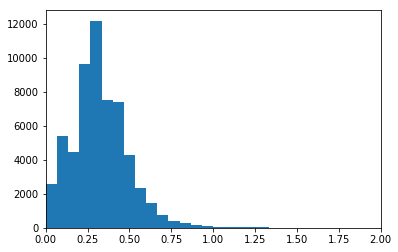

In [17]:
valid_gamma = gamma[~np.isnan(gamma)]
valid_gamma[valid_gamma > 2] = 2

plt.hist(valid_gamma, 30)
plt.xlim([0,2])

In [18]:
np.sum(valid_gamma <= 1) / len(valid_gamma)

0.9955721552787683

In [26]:
slice_start = 5
slice_end   = len(z_reference)

C:\Users\kriol\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


Slice = 5
(45, 90) 45 90


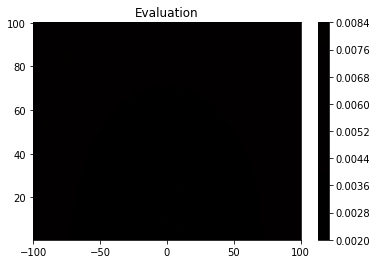

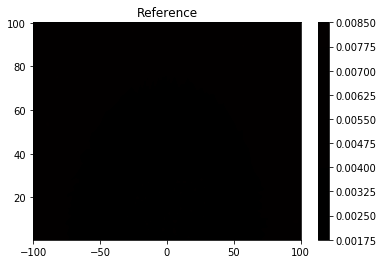

C:\Users\kriol\Anaconda3\lib\site-packages\matplotlib\contour.py:1533: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
C:\Users\kriol\Anaconda3\lib\site-packages\matplotlib\contour.py:1534: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


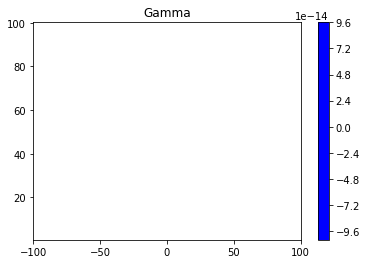



Slice = 15
(45, 90) 45 90


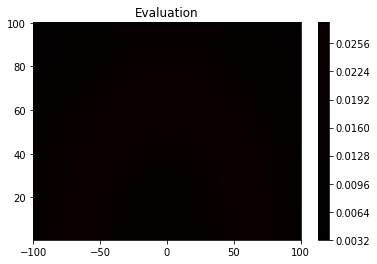

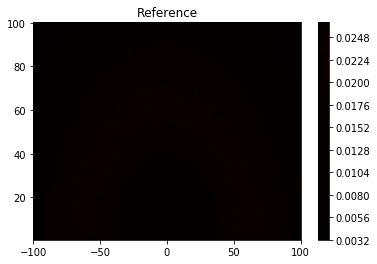

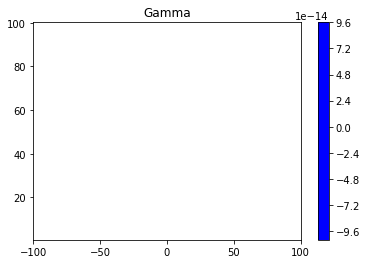



Slice = 25
(45, 90) 45 90


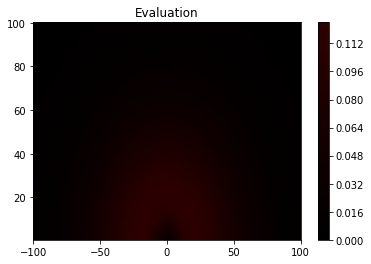

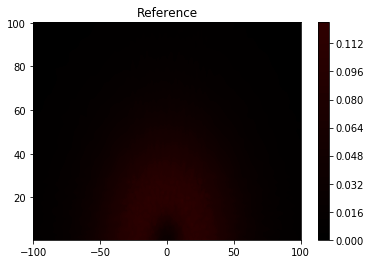

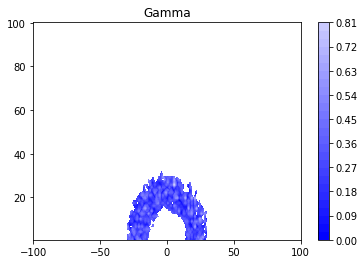



Slice = 35
(45, 90) 45 90


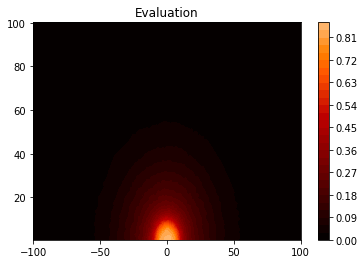

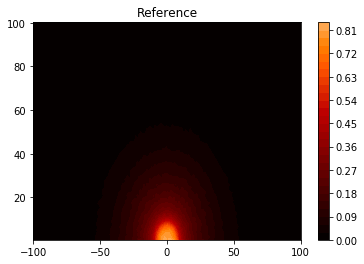

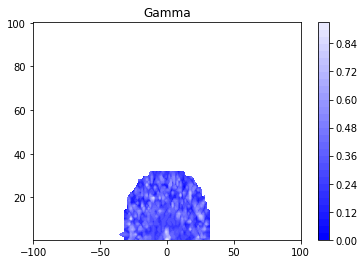



Slice = 45
(45, 90) 45 90


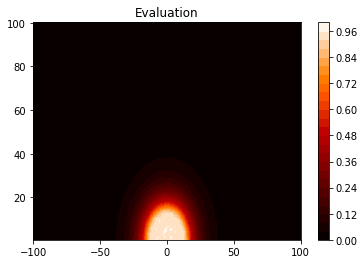

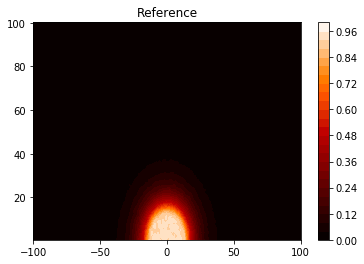

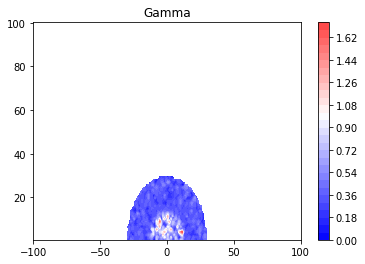



Slice = 55
(45, 90) 45 90


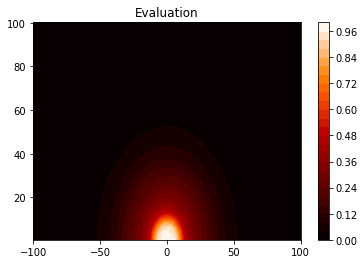

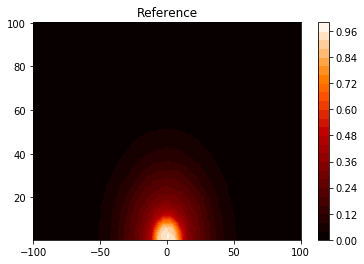

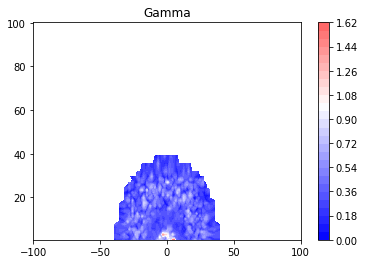



Slice = 65
(45, 90) 45 90


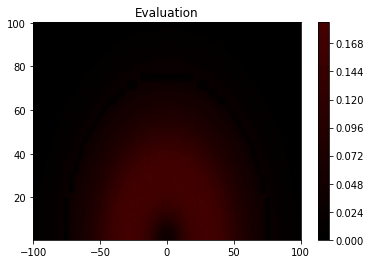

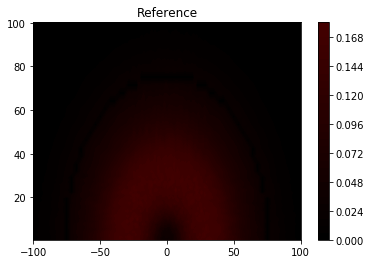

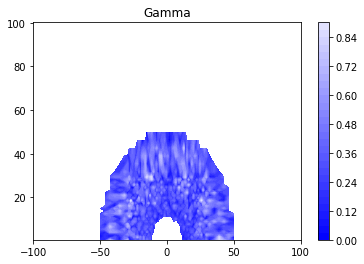



Slice = 75
(45, 90) 45 90


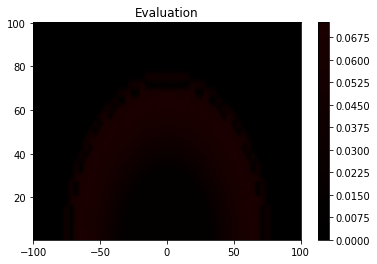

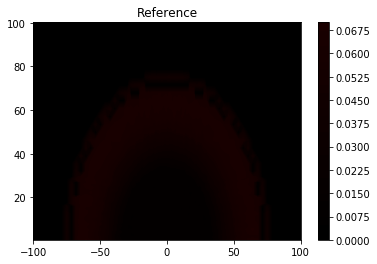

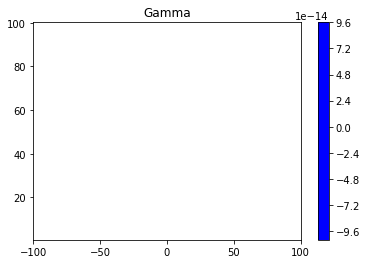



Slice = 85
(45, 90) 45 90


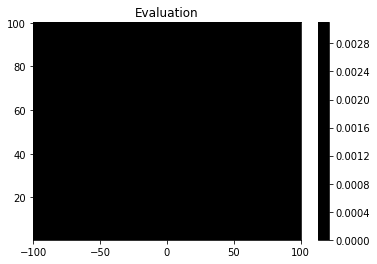

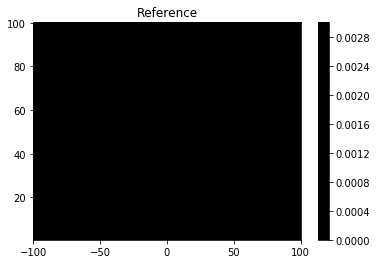

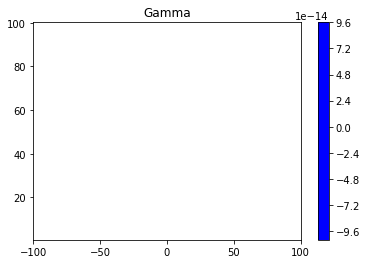



Slice = 95
(45, 90) 45 90


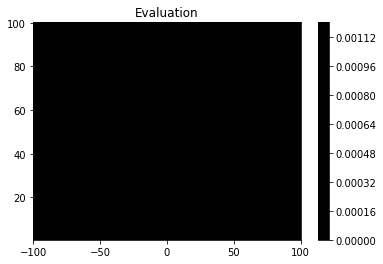

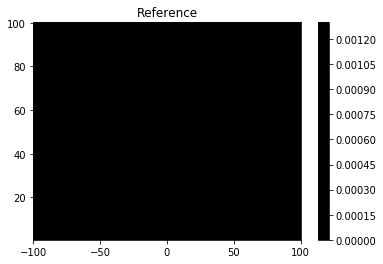

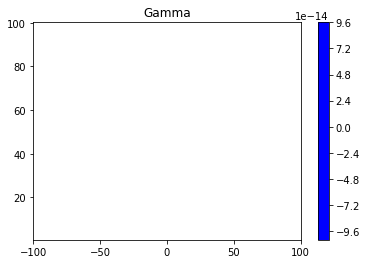

In [40]:
max_ref_dose = np.max(dose_reference)

cut_off_gamma = gamma.copy()
greater_than_2_ref = (cut_off_gamma > 2) & ~np.isnan(cut_off_gamma)
cut_off_gamma[greater_than_2_ref] = 2

for z_i in range(slice_start,slice_end,10):
    print("======================================================================")
    print("Slice = {0}".format(z_i))  
   
    slice_eval = dose_evaluation[:, :, z_i] / max_ref_dose
    print(slice_eval.shape, len(x_evaluation), len(y_evaluation))
    plt.contourf(y_evaluation, x_evaluation, slice_eval, 30, vmin=0, vmax=1.0, cmap=plt.get_cmap('gist_heat'))
    plt.title("Evaluation")
    plt.colorbar()
    plt.show()
    
    slice_ref = dose_reference[:, :, z_i] / max_ref_dose
    plt.contourf(y_reference, x_reference, slice_ref, 30, vmin=0, vmax=1.0, cmap=plt.get_cmap('gist_heat'))
    plt.title("Reference")
    plt.colorbar()
    plt.show()
    
    plt.contourf(y_evaluation, x_evaluation, cut_off_gamma[:, :, z_i], 30, vmin=0, vmax=2, cmap=plt.get_cmap('bwr'))    
    plt.title("Gamma")
    plt.colorbar()
    plt.show()
          
    print("\n")